In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Common Preprocessing Function
def apply_preprocessing(img, size=(512, 512)):
    """
    Converts image to grayscale, resizes it, and applies CLAHE for contrast enhancement.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img
    resized = cv2.resize(gray, size)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(resized)
    return enhanced

In [3]:
# DRIVE Dataset Preprocessing
# =======================
def preprocess_drive_dataset(images_dir, masks_dir=None, roi_masks_dir=None, size=(512, 512)):
    """
    Preprocesses the DRIVE dataset images with optional ROI masking and ground truth masks.
    Returns a list of preprocessed images and optionally their corresponding masks.
    """
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.tif')])
    preprocessed_images, preprocessed_masks = [], []

    for file in image_files:
        img_path = os.path.join(images_dir, file)
        img = np.array(Image.open(img_path).convert('RGB'))

        # Apply ROI mask if provided
        if roi_masks_dir:
            roi_name = file.replace('.tif', '_mask.gif')
            roi_path = os.path.join(roi_masks_dir, roi_name)
            if os.path.exists(roi_path):
                roi_mask = cv2.resize(np.array(Image.open(roi_path)), img.shape[:2][::-1])
                img = cv2.bitwise_and(img, img, mask=roi_mask)

        # Apply preprocessing pipeline
        preprocessed_images.append(apply_preprocessing(img, size))

        # Load and preprocess corresponding mask if available
        if masks_dir:
            base = file.replace('_training.tif', '').replace('.tif', '')
            mask_path = os.path.join(masks_dir, f"{base}_manual1.gif")
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                mask = cv2.resize(np.array(mask), size, interpolation=cv2.INTER_NEAREST)
                mask = (mask > 127).astype(np.uint8) * 255
                preprocessed_masks.append(mask)

    return (preprocessed_images, preprocessed_masks) if masks_dir else preprocessed_images


In [12]:
# STARE Dataset Preprocessing
def preprocess_stare_dataset(stare_dir, size=(512, 512)):
    """
    Preprocesses STARE dataset images (no ground truth masks available).
    Returns a list of preprocessed images.
    """
    image_files = [f for f in sorted(os.listdir(stare_dir)) if f.endswith(".ppm")]
    preprocessed_images = []

    for file in image_files:
        path = os.path.join(stare_dir, file)  # Fixed variable name
        img = np.array(Image.open(path).convert('RGB'))
        preprocessed_images.append(apply_preprocessing(img, size))

    return preprocessed_images

In [14]:
# CHASE_DB1 Dataset Preprocessing
# =======================
def preprocess_chasedb_dataset(images_dir, masks_dir=None, size=(512, 512)):
    """
    Preprocesses CHASE_DB1 dataset images with optional ground truth vessel masks.
    Returns a list of preprocessed images and optionally their corresponding masks.
    """
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
    preprocessed_images, preprocessed_masks = [], []

    for file in image_files:
        img_path = os.path.join(images_dir, file)
        img = np.array(Image.open(img_path).convert('RGB'))
        preprocessed_images.append(apply_preprocessing(img, size))

        if masks_dir:
            base = file.replace('.jpg', '')
            mask_path = os.path.join(masks_dir, f"{base}_1stHO.png")
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                mask = cv2.resize(np.array(mask), size, interpolation=cv2.INTER_NEAREST)
                mask = (mask > 127).astype(np.uint8) * 255
                preprocessed_masks.append(mask)

    return (preprocessed_images, preprocessed_masks) if masks_dir else preprocessed_images


In [15]:
# Utility Function to Display Samples
# =======================
def display_samples(original_dir, preprocessed_imgs, count=5, extensions=['.tif', '.ppm', '.jpg']):
    """
    Displays side-by-side comparison of original and preprocessed images.
    """
    image_files = sorted([f for f in os.listdir(original_dir) if any(f.endswith(ext) for ext in extensions)])

    for i in range(min(count, len(preprocessed_imgs))):
        orig = np.array(Image.open(os.path.join(original_dir, image_files[i])).convert('RGB'))
        pre = preprocessed_imgs[i]

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pre, cmap='gray')
        plt.title("Preprocessed")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

DRIVE DATASET


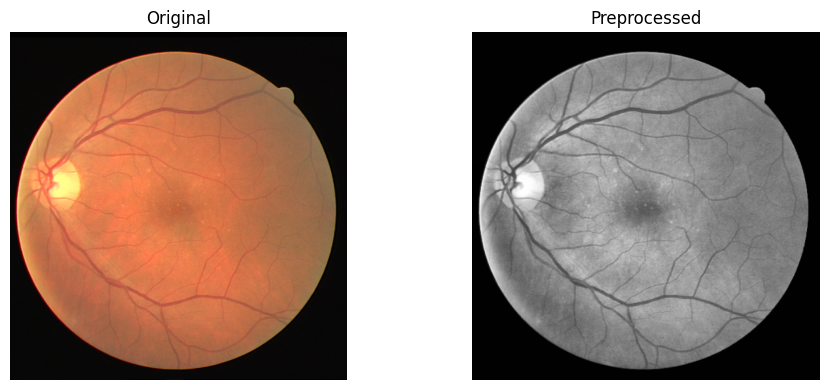

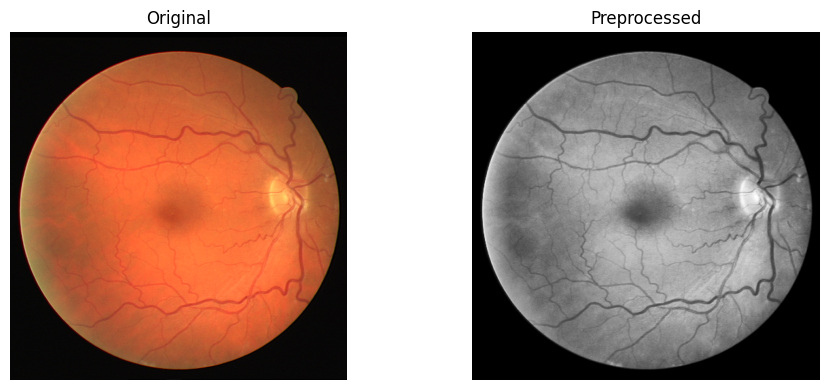

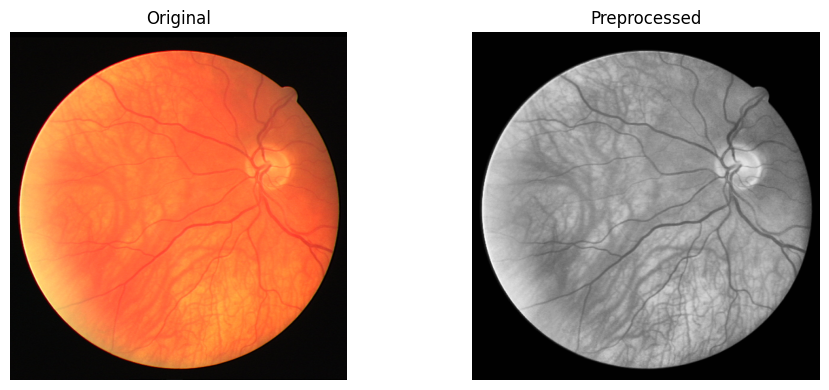

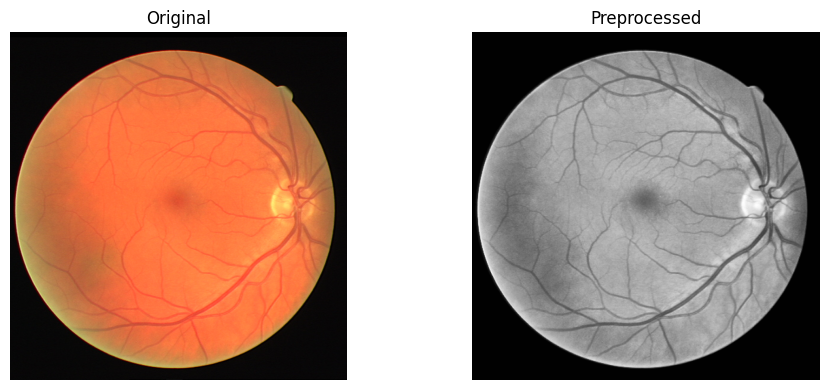

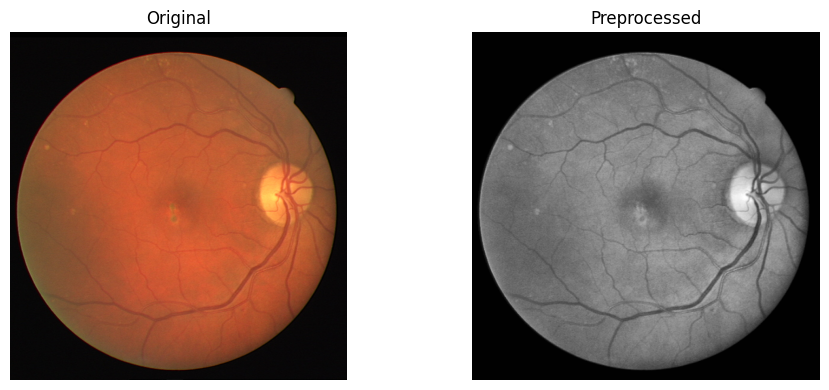


STARE DATASET


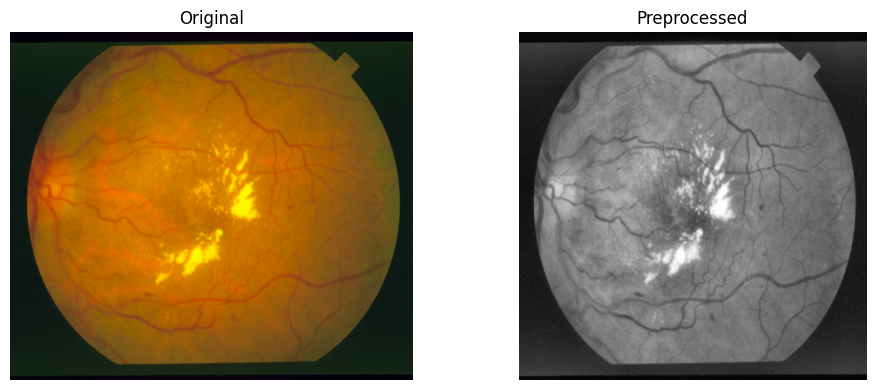

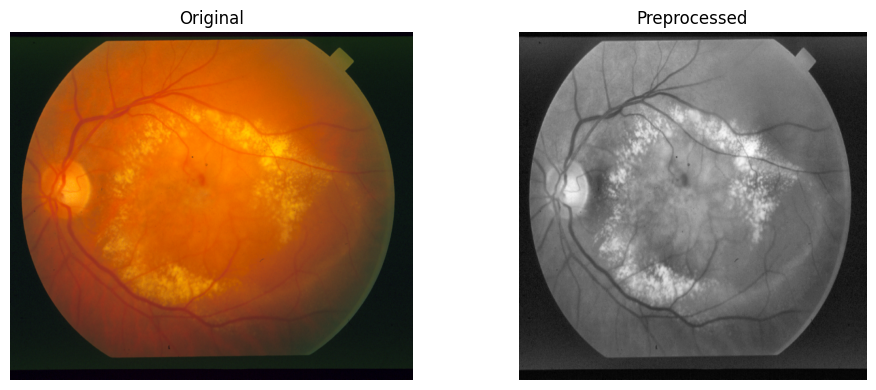

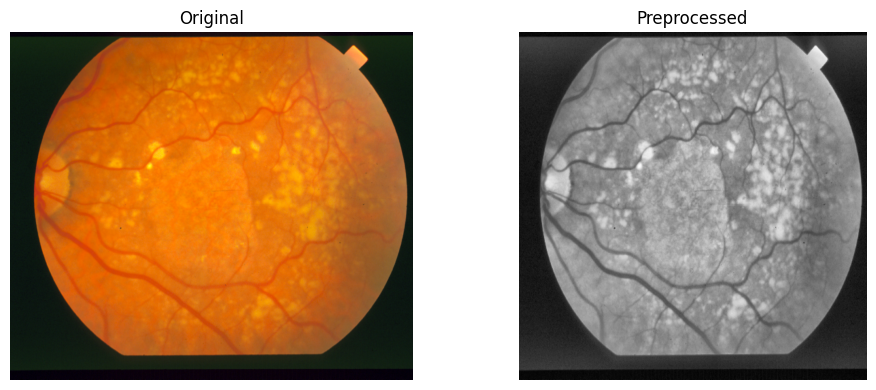

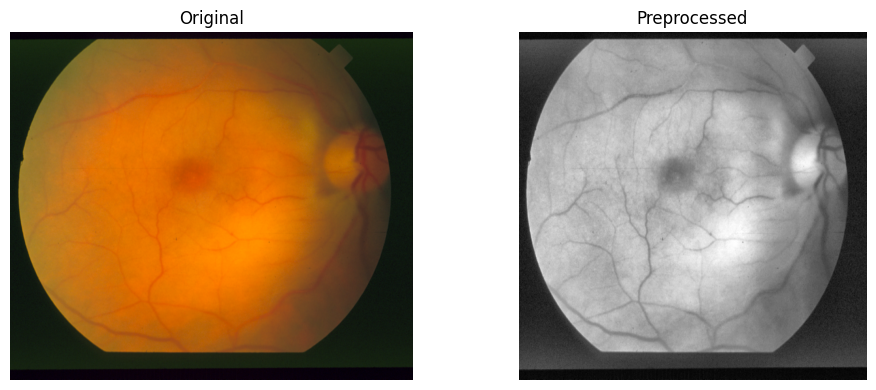

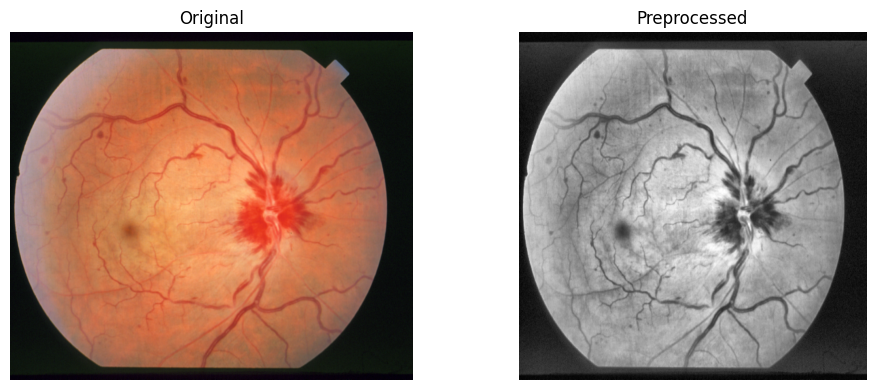


CHASE_DB1 DATASET


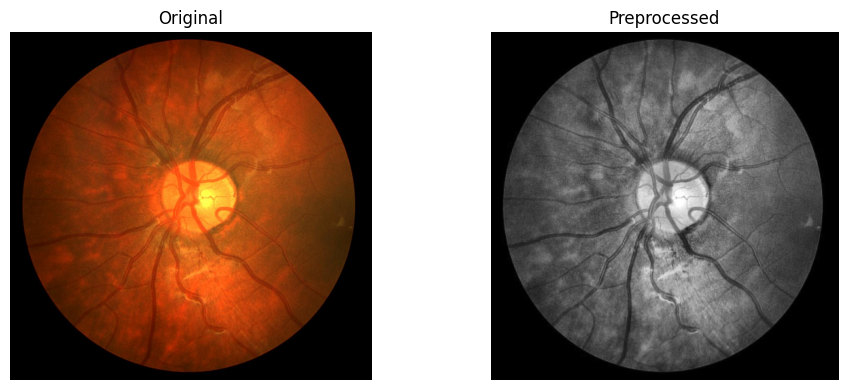

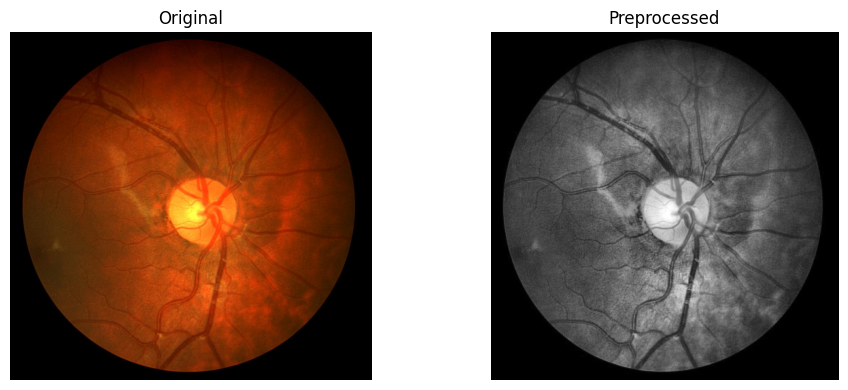

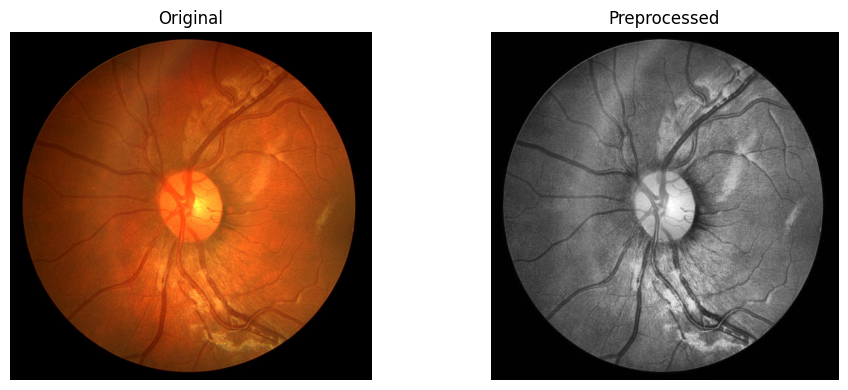

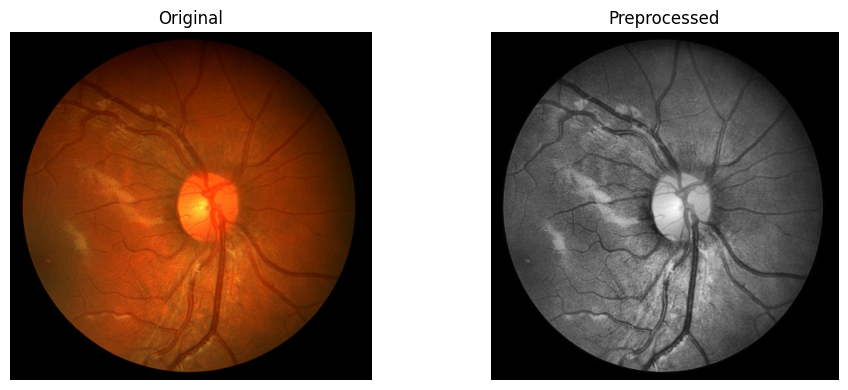

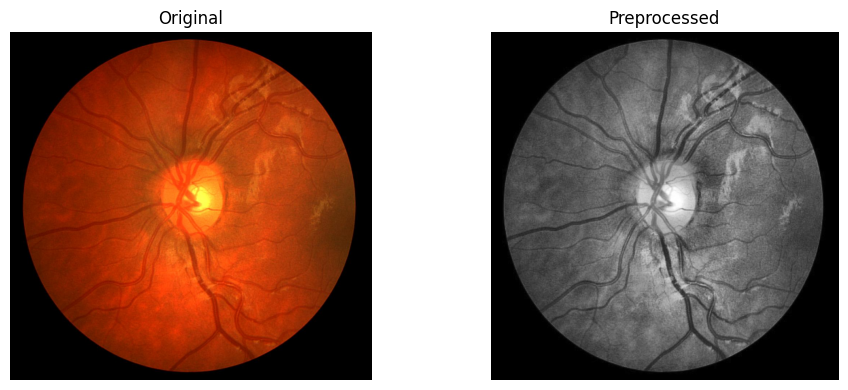

In [19]:
# DRIVE
drive_imgs, drive_masks = preprocess_drive_dataset(
    images_dir="DRIVE/training/images",
    masks_dir="DRIVE/training/1st_manual",
    roi_masks_dir="DRIVE/training/mask"
)
print("DRIVE DATASET")
display_samples("DRIVE/training/images", drive_imgs)
print("==================================================================================\n")
# STARE
stare_imgs = preprocess_stare_dataset("STARE")
print("STARE DATASET")
display_samples("STARE", stare_imgs, count=5)
print("==================================================================================\n")

# CHASE_DB1
chase_imgs, chase_masks = preprocess_chasedb_dataset(
    images_dir="CHASE_DB1/images",
    masks_dir="CHASE_DB1/1st_label"
)
print("CHASE_DB1 DATASET")
display_samples("CHASE_DB1/images", chase_imgs, extensions=['.jpg'])
print("==================================================================================\n")